## Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd

from harp_resources import process, utils
from sleap import load_and_process as lp

In [2]:
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_230824/2024-08-23T14-14-16_B3M4')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_230824/photometry/B3M4_MMclosed&Regular_day2/2024_08_23-16_17_49')

## Videography and SLEAP

In [4]:
lp.create_flipped_videos(data_path, what_to_flip='VideoData1')

Flipped video saved as: /home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_230824/2024-08-23T14-14-16_B3M4/VideoData1/VideoData1_1904-01-06T03-00-00.flipped.avi


## RUN Sleap inference now

In [5]:
VideoData1, VideoData2 = lp.load_videography_data(data_path)

INFO:
load_and_process.load_videography_data() function expects the following format of SLEAP outputs:
"VideoData1_1904-01-01T00-00-00.sleap.csv"
"VideoData1_1904-01-01T23-59-59.sleap.csv"
"..."
Please make sure to rename SLEAP files if they are not already following this convention.


RESULTS:
Outputs of SLEAP found in VideoData1: False
Outputs of SLEAP found in VideoData2: True
Found .csv VideoData logs timestamped at:
- 1904-01-06T03:00:00.000000000
Reading dataframes finished.
VideoData2 SLEAP output: 114983 frames registered, but 114584 rows found inside file. Filling with empty rows.


In [7]:
# SLEAP processing

VideoData2 = VideoData2.interpolate()

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict =lp.get_coordinates_dict(VideoData2, columns_of_interest)

theta = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
center_point = lp.get_left_right_center_point(coordinates_dict)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
remformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, columns_of_interest)
centered_coordinates_dict = lp.get_centered_coordinates_dict(remformatted_coordinates_dict, center_point)
rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

columns_of_interest = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict, columns_of_interest)

SleapData = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, ellipse_parameters_data[:,0], ellipse_parameters_data[:,1], ellipse_parameters_data[:,2], ellipse_center_points_data[:,0], ellipse_center_points_data[:,1]])

## Loading and Synchronisation 

In [9]:
conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=True)

OnixAnalogClock loaded in 0.88 seconds.
Following conversion functions calculated:
	onix_to_harp_timestamp
	harp_to_onix_clock
	photometry_to_harp_time
	onix_time_to_photometry

Usage example 1: plotting photodiode signal for three halts

	# Loading data
	OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
	OnixAnalogData = utils.read_OnixAnalogData(data_path)
	ExperimentEvents = utils.read_ExperimentEvents(data_path)

	# Selecting desired HARP times, applying conversion to ONIX time
	start_harp_time_of_halt_one = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
	start_harp_time_of_halt_four = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[3].Seconds
	start_onix_time = conversions['harp_to_onix_clock'](start_harp_time_of_halt_one - 1)
	end_onix_time = conversions['harp_to_onix_clock'](start_harp_time_of_halt_four)

	# Selecting photodiode times and data within the range, converting back to HARP and plotting
	indices = np.where(np.logical_a

In [10]:
streams = utils.load_registers(data_path)

Photometry = utils.read_fluorescence(photometry_path)
Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])

streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'], index_column_name='HARP Timestamps')
streams = process.reformat_and_add_many_streams(streams, SleapData, 'Eye Movements', ['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='0.1ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

Dataset 2024-08-23T14-14-16_B3M4 contains following registers:
H1: [46, 32, 33]
H2: [42, 39]
Registers loaded in 2.14 seconds.
Global first timestamp: 1904-01-06 03:09:48.814600128
Global last timestamp: 1904-01-06 03:42:07.582796833
Global length: 0 days 00:32:18.768196705

H1
OpticalTrackingRead0X(46): 
	first  1904-01-06 03:10:01.540256 
	last   1904-01-06 03:41:57.710240 
	length 0 days 00:31:56.169984 
	mean difference between timestamps 0 days 00:00:00.009999999
OpticalTrackingRead0Y(46): 
	first  1904-01-06 03:10:01.540256 
	last   1904-01-06 03:41:57.710240 
	length 0 days 00:31:56.169984 
	mean difference between timestamps 0 days 00:00:00.009999999
OpticalTrackingRead0Brightness(46): 
	first  1904-01-06 03:10:01.540256 
	last   1904-01-06 03:41:57.710240 
	length 0 days 00:31:56.169984 
	mean difference between timestamps 0 days 00:00:00.009999999
OpticalTrackingRead1X(46): 
	first  1904-01-06 03:10:01.540256 
	last   1904-01-06 03:41:57.710240 
	length 0 days 00:31:56.169984

In [11]:
Photometry

,TimeStamp,Events,CH1-410,CH1-470,CH1-560,HARP Timestamps
0,0.000,NaN,66.652,141.911,39.889,1904-01-06 03:09:48.814600128
1,100.000,NaN,66.010,141.745,39.883,1904-01-06 03:09:48.914601437
2,200.001,NaN,66.060,142.102,39.817,1904-01-06 03:09:49.014603746
3,300.005,NaN,66.280,142.081,39.835,1904-01-06 03:09:49.114609055
4,400.005,NaN,66.220,141.448,39.879,1904-01-06 03:09:49.214610364
...,...,...,...,...,...,...
19386,1938342.880,NaN,55.960,132.706,37.348,1904-01-06 03:42:07.182854597
19387,1938442.863,NaN,56.377,132.897,37.418,1904-01-06 03:42:07.282838906
19388,1938542.846,NaN,56.457,132.513,37.375,1904-01-06 03:42:07.382823215
19389,1938642.834,NaN,56.376,132.817,37.450,1904-01-06 03:42:07.482812524


OnixAnalogClock loaded in 0.88 seconds.
OnixAnalogData loaded in 2.51 seconds.
Selection of photodiode data finished in 0.76 seconds.


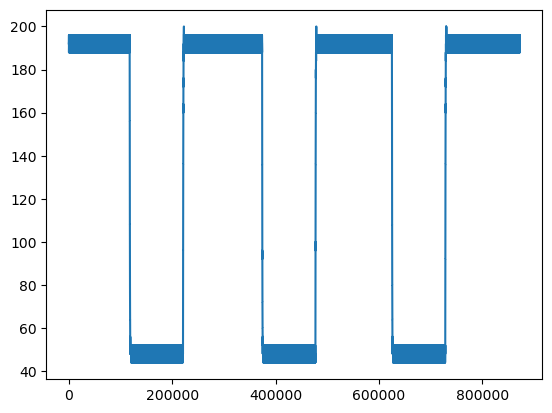

In [31]:
# Loading data
OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
ExperimentEvents = utils.read_ExperimentEvents(data_path)

# Selecting desired HARP times, applying conversion to ONIX time
start_harp_time_of_halt_one = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
start_harp_time_of_halt_four = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[3].Seconds

# Selecting photodiode times and data within the range, converting back to HARP and plotting
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, start_harp_time_of_halt_one - 1, start_harp_time_of_halt_four, conversions)

plt.plot(selected_harp_times, selected_photodiode_data[:, 0])
plt.show()

## Usage

In [14]:
running = resampled_streams['H1']['OpticalTrackingRead0X(46)']
rotation = resampled_streams['H1']['OpticalTrackingRead0Y(46)']
photometry = resampled_streams['Photometry']['CH1-470']
eye_movements = resampled_streams['Eye Movements']['Ellipse.Center.X']

In [17]:
def running_unit_conversion(running_array): #for ball linear movement
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46) -this is sensor specific. current sensor samples at 100 hz 
    linear_velocity = meters_per_count / dt # meters per second per count
    
    return running_array * linear_velocity

In [18]:
def rotation_unit_conversion(rotation_array): # for ball rotation
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46) -this is sensor specific. current sensor samples at 100 hz 
    linear_velocity = meters_per_count / dt # meters per second per count
    
    ball_radius = 0.1 # meters 
    angular_velocity = linear_velocity / ball_radius # radians per second per count
    angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
    
    return rotation_array * angular_velocity

In [19]:
running = running_unit_conversion(running) # meters per second
running *= 100 # centimeters per second

In [20]:
rotation = rotation_unit_conversion(rotation) # degrees per second

0.12127606663602424


In [ ]:
#pupil_diameter = elipse.hight + elipse.width /2

Selection of photodiode data finished in 2.37 seconds.


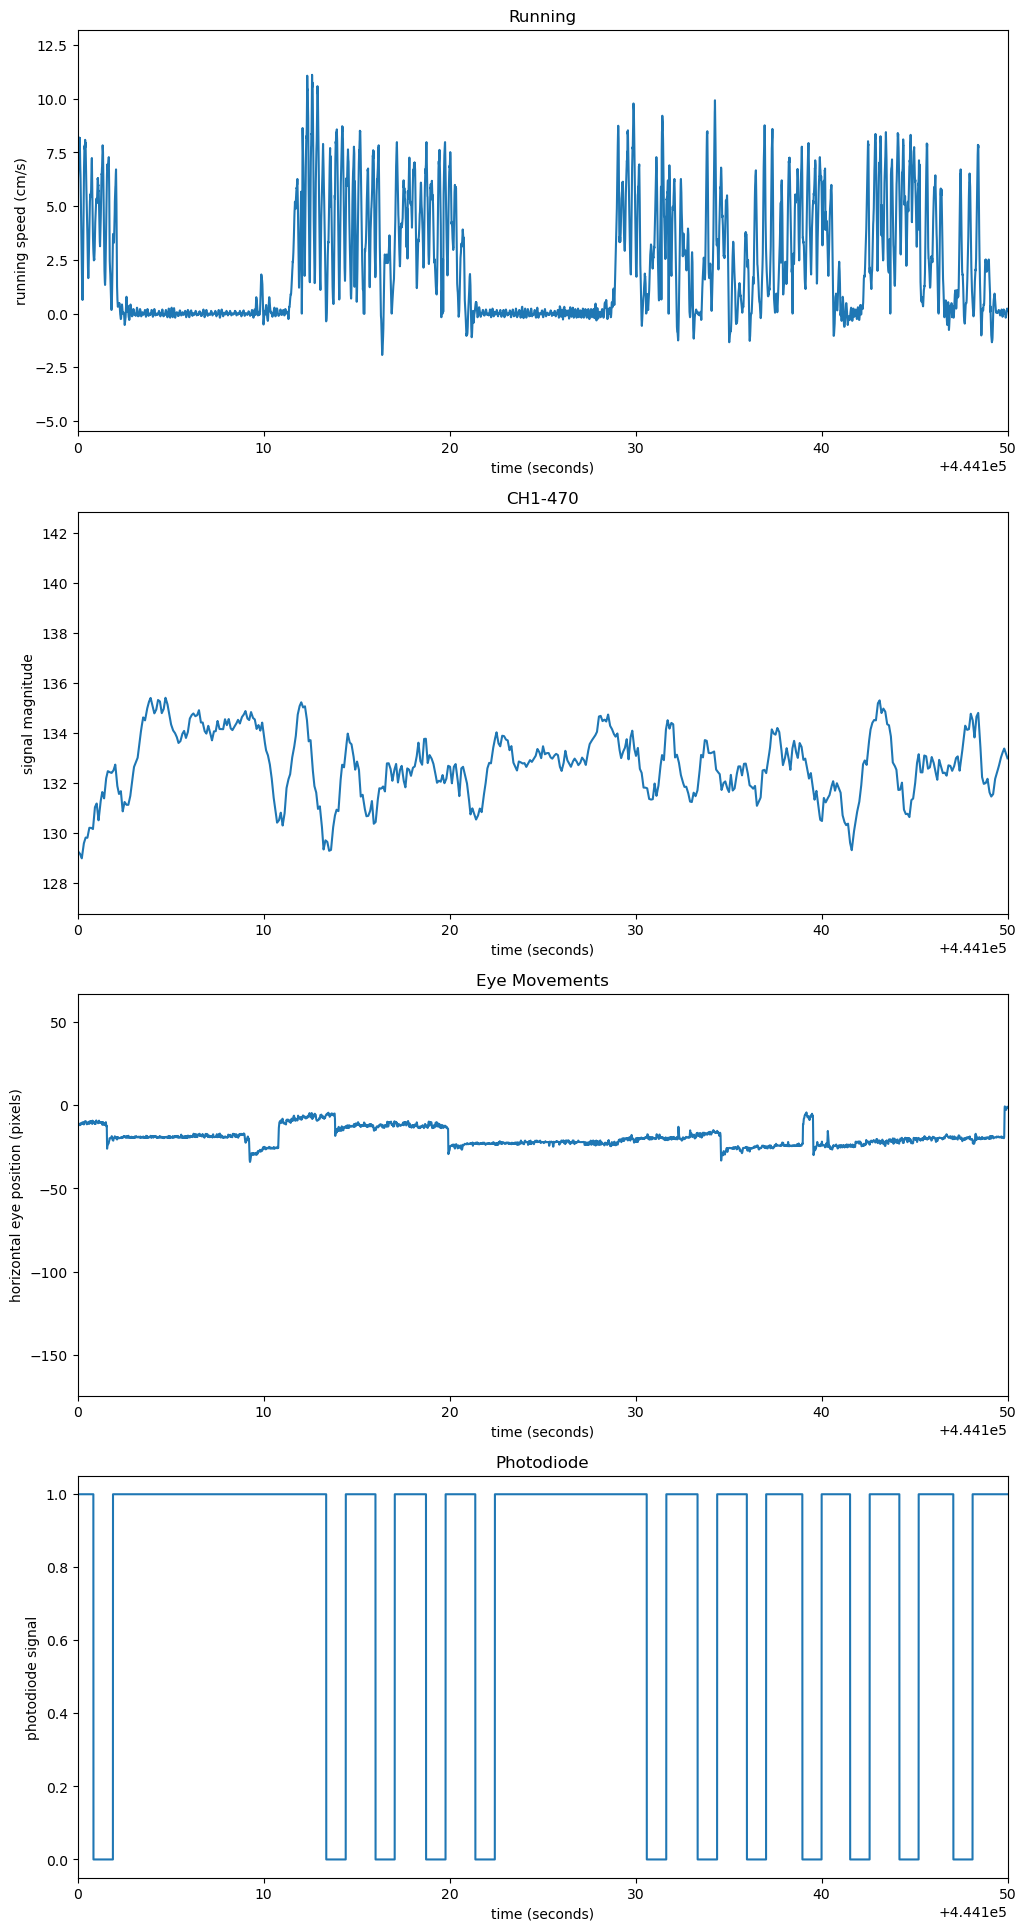

In [21]:
#A = None #time window beginning in harp seconds, min different from dataset to dataset, None means from start
#B = None #time window end in harp seconds, None means to end 
A = 444100 
B = A + 50

photodiode_x, photodiode_y = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,24))

t = (running.index - utils.harp.REFERENCE_EPOCH).total_seconds() #date stamp to seconds 

ax[0].plot(t, running)
ax[0].set_title('Running')
ax[0].set_xlim([A,B])
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')

ax[1].plot(t, photometry)
ax[1].set_title('CH1-470')
ax[1].set_xlim([A,B])
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal magnitude')

ax[2].plot(t, eye_movements)
ax[2].set_title('Eye Movements')
ax[2].set_xlim([A,B])
ax[2].set_xlabel('time (seconds)')
ax[2].set_ylabel('horizontal eye position (pixels)')

ax[3].plot(process.convert_datetime_to_seconds(photodiode_x), photodiode_y[:,0])
ax[3].set_title('Photodiode')
ax[3].set_xlim([A,B])
ax[3].set_xlabel('time (seconds)')
ax[3].set_ylabel('photodiode signal')

plt.show()

In [ ]:
# save resampled data as CSV with header, have a column with time  
# on top of registers, save running (cm/s) and rotation (deg/s) as well as pupil_diameter (px)
#process.save_streams_to_excel('/home/ikharitonov/Desktop/export_test.xlsx', resampled_streams)

In [32]:
resampled_streams

{'H1': {'OpticalTrackingRead0X(46)': 1904-01-06 03:09:48.814600    0.000000
  1904-01-06 03:09:48.814700    0.000754
  1904-01-06 03:09:48.814800    0.001509
  1904-01-06 03:09:48.814900    0.002263
  1904-01-06 03:09:48.815000    0.003018
                                  ...   
  1904-01-06 03:42:07.582300    0.004092
  1904-01-06 03:42:07.582400    0.003069
  1904-01-06 03:42:07.582500    0.002046
  1904-01-06 03:42:07.582600    0.001023
  1904-01-06 03:42:07.582700    0.000000
  Freq: 100us, Length: 19387682, dtype: float64,
  'OpticalTrackingRead0Y(46)': 1904-01-06 03:09:48.814600    0.000000
  1904-01-06 03:09:48.814700    0.000008
  1904-01-06 03:09:48.814800    0.000016
  1904-01-06 03:09:48.814900    0.000024
  1904-01-06 03:09:48.815000    0.000031
                                  ...   
  1904-01-06 03:42:07.582300    0.000162
  1904-01-06 03:42:07.582400    0.000122
  1904-01-06 03:42:07.582500    0.000081
  1904-01-06 03:42:07.582600    0.000041
  1904-01-06 03:42:07.5827